In [18]:
import netket as nk
import numpy as np
import json
import matplotlib.pyplot as plt

In [34]:
N=8

In [35]:
#graph = nk.graph.Hypercube(length=N, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, N=N)  #total_sz=0,
h=1

# TFIM Hamiltonian: H = - sum(Sz_i Sz_{i+1}) - h sum(Sx_i)
edges = [[i, (i + 1) % N] for i in range(N)]  # Periodic boundary conditions

H = nk.operator.LocalOperator(hi)

# interaction term Sz_i Sz_{i+1}
for i, j in edges:
    H += -1.0 * nk.operator.spin.sigmaz(hi, i) * nk.operator.spin.sigmaz(hi, j)

# transverse field term -h * Sx_i
for i in range(N):
    H += -h * nk.operator.spin.sigmax(hi, i)

lmbd,eigvec=np.linalg.eigh(H.to_dense())
print("Ground State Energy: ",lmbd[0])

Ground State Energy:  -10.25166179096602


In [75]:
alpha = 1
model = nk.models.RBM(alpha=alpha, use_visible_bias=True, param_dtype=complex)
vstate = nk.vqs.MCState(nk.sampler.MetropolisLocal(hilbert=hi), model, n_samples=10000)
optimizer = nk.optimizer.Adam(learning_rate=0.004)

In [76]:
log = nk.logging.RuntimeLog()

gs = nk.driver.VMC(H, optimizer, variational_state=vstate)
gs.run(n_iter=200, out=log)

print("Final ground state energy: ", vstate.expect(H))

100%|██████████| 200/200 [00:19<00:00, 10.02it/s, Energy=-10.1747+0.0019j ± 0.0043 [σ²=0.1557, R̂=1.0012]]


Final ground state energy:  -10.1749+0.0014j ± 0.0044 [σ²=0.1650, R̂=1.0009]


In [77]:
x = np.real(log.data["Energy"].iters)
y = np.real(log.data["Energy"].Mean)
yerr = np.real(log.data["Energy"].Sigma)

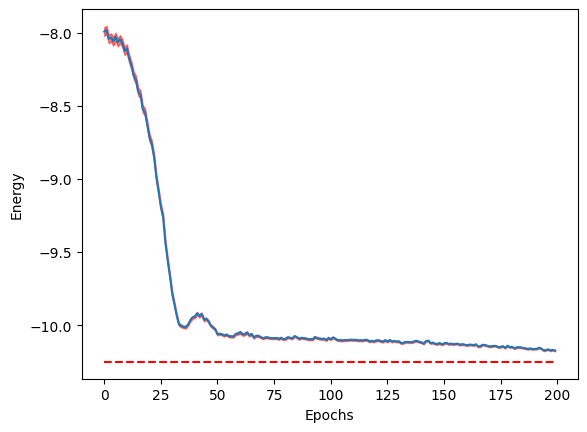

In [78]:
fig, ax = plt.subplots()
ax.plot(y)
ax.fill_between(x, (y-yerr), (y+yerr), color='r', alpha=.5)
ax.set_ylabel("Energy")
ax.set_xlabel("Epochs")
plt.hlines(lmbd[0],0,len(x)-1,color='r',linestyles='dashed')
plt.show()

In [70]:
# rng = np.random.default_rng(seed=123)  # For reproducibility
# parameters = vstate.parameters

# parameters["Dense"]["bias"] = rng.normal(loc=0.0, scale=0.01, size=parameters["Dense"]["bias"].shape) + 1j * rng.normal(loc=0.0, scale=0.01, size=parameters["Dense"]["bias"].shape)
# parameters["Dense"]["kernel"] = rng.normal(loc=0.0, scale=0.01, size=parameters["Dense"]["kernel"].shape) + 1j * rng.normal(loc=0.0, scale=0.01, size=parameters["Dense"]["kernel"].shape)
# parameters["visible_bias"] = rng.normal(loc=0.0, scale=0.01, size=parameters["visible_bias"].shape) + 1j * rng.normal(loc=0.0, scale=0.01, size=parameters["visible_bias"].shape)

# vstate.parameters = parameters  # Update the parameters in the variational state

# print("Initial RBM Parameters:")
# print("Weights (kernel):", parameters["Dense"]["kernel"])
# print("Hidden biases (Dense bias):", parameters["Dense"]["bias"])
# print("Visible biases:", parameters["visible_bias"])

In [68]:
# print("Initial RBM Parameters:")
# print("Weights (kernel):", vstate.parameters["Dense"]["kernel"])
# print("Hidden biases (Dense bias):", vstate.parameters["Dense"]["bias"])
# print("Visible biases:", vstate.parameters["visible_bias"])

In [69]:
gs = vstate.to_array()